## 1、定义算法
强化学习算法的模式都比较固定，一般包括sample（即训练时采样动作），predict（测试时预测动作），update（算法更新）以及保存模型和加载模型等几个方法，其中对于每种算法samle和update的方式是不相同，而其他方法就大同小异。

In [36]:
import numpy as np
import math
import torch
from collections import defaultdict

class QLearning(object):
    def __init__(self,n_actions,cfg):
        self.n_actions = n_actions 
        self.lr = cfg.lr  
        self.gamma = cfg.gamma  
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  # 采样次数
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表
    def sample_action(self, state):
        ''' 采样动作，训练时用
        '''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择Q(s,a)最大对应的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选择动作
        return action
    def predict_action(self,state):
        ''' 预测或选择动作，测试时用
        '''
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[str(state)][action] 
        if terminated: # 终止状态
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

## 2、定义训练
强化学习算法的训练方式也比较固定，如下：

```python
for i_ep in range(train_eps): # 遍历每个回合
    # 重置环境，获取初始状态
    state = env.reset()  # 重置环境,即开始新的回合
    while True: # 对于比较复杂的游戏可以设置每回合最大的步长，例如while ep_step<100，即最大步长为100。
        # 智能体根据策略采样动作
        action = agent.sample_action(state)  # 根据算法采样一个动作
        # 与环境进行一次交互，得到下一个状态和奖励
        next_state, reward, terminated, _ = env.step(action)  # 智能体将样本记录到经验池中
        agent.memory.push(state, action, reward, next_state, terminated) 
        # 智能体更新策略
        agent.update(state, action, reward, next_state, terminated)  
        # 更新状态
        state = next_state  
        # 如果终止则本回合结束
        if terminated:
            break
```
首先对于每个回合，回合开始时环境需要重置，好比我们每次开一把游戏需要从头再来一样。我们可以设置智能体在每回合数的最大步长，尤其是对于比较复杂的游戏，这样做的好处之一就是帮助智能体在训练中快速收敛，比如我们先验地知道最优解的大概步数，那么理论上智能体收敛时也应该是这个步数附近，设置最大步数可以方便智能体接近这个最优解。在每个回合中，智能体首先需要采样（sample），或者说采用探索策略例如常见的$\varepsilon$-greedy策略或者UCB探索策略等等。采样的过程是将当前的状态state作为输入，智能体采样输出动作action。然后环境根据采样出来的动作反馈出下一个状态以及相应的reward等信息。接下来对于具有memory的智能体例如包含replay memory的DQN来说，需要将相应的transition（记住这个词，中文不好翻译，通常是状态、动作、奖励等信息）。紧接着就是智能体更新，对于深度强化学习此时一般从memory中随机采样一些transition进行更新，对于Q learning一般是采样上一次的transition。更新公式是比较关键的部分，但是也很通用，一般基于值的算法更新公式都是一个套路如下：
$$
y_{j}= \begin{cases}r_{j} & \text { for terminal } s_{t+1} \\ r_{j}+\gamma \max _{a^{\prime}} Q\left(s_{t+1}, a^{\prime} ; \theta\right) & \text { for non-terminal } s_{t+1}\end{cases}
$$
智能体更新完之后，通常需要更新状态，即```state = next_state```，然后会检查是否完成了这一回合的游戏，即```terminated==True```，注意完成并不代表这回合成功，也有可能是失败的太离谱，等同学们有了自定义强化学习环境的经验就知道了（等你长大就知道了XD）。
如果需要记录奖励、损失等等的话可以再加上，如下方代码，实际项目中更多地使用tensorboard来记录相应的数据，甚至于笔者就在这些教学代码中使用过，但是看起来有些繁琐，容易给大家增加不必要的学习难度，因此学有余力以及需要在项目研究中做强化学习的可以去看看，也很简单。
此外稍微复杂一些的强化学习不是一次性写完代码就能收敛的，这时需要我们做一个调参侠。为了检查我们参数调得好不好，可以在终端print出奖励、损失以及epsilon等随着回合数的变化，这点说明一下强化学习的训练过程一般都是先探索然后收敛的，官方的话就是权衡exploration and exploitation。e-greedy策略的做法就是前期探索，然后逐渐减小探索率至慢慢收敛，也就是这个epsilon。这个值越大比如0.9就说明智能体90%的概率在随机探索，通常情况下会设置三个值，epsilon_start、epsilon_end以及epsilon_decay，即初始值、终止值和衰减率，其中初始值一般是0.95不变，终止值是0.01，也就是说即使在收敛阶段也让智能体保持很小概率的探索，这样做的原因就是智能体已经学出了一个不错的策略，但是保不齐还有更好的策略，好比我们知道要出人头地学历高比较重要，但是“人还是要有梦想的，万一实现了呢”，总是存在意外的可能，对吧。回归正题，比较关键的是epsilon_decay这个衰减率，这个epsilon衰减太快了学来的策略往往过拟合，好比一条只能选择一朵花的花道上，你早早选择了一朵看起来还可以的花，却错过了后面更多的好花。但是衰减的太慢会影响收敛的速度，好比你走过了花道的尽头也还没选出一朵花来，相比前者不如更甚。当然强化学习的调参相比于深度学习只能说是有过之无不及，比较复杂，不止epsilon这一个，这就需要同学们的耐心学习了。
强化学习测试的代码跟训练基本上是一样的，因此我放到同一个代码段里。相比于训练代码，测试代码主要有以下几点不同：1、测试模型的过程是不需要更新的，这个是不言而喻的；2、测试代码不需要采样（sample）动作，相比之代替的是预测（sample）动作，其区别就是采样动作时可能会使用各种策略例如$\varepsilon$-greedy策略，而预测动作不需要，只需要根据训练时学习好的Q表或者网络模型代入状态得到动作即可；3、测试过程终端一般只需要看奖励，不需要看epislon等，反正它在测试中也是无意义的。

In [37]:
def train(cfg,env,agent):
    print('开始训练！')
    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
    rewards = []  # 记录奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        state = env.reset(seed=cfg.seed)  # 重置环境,即开始新的回合
        while True:
            action = agent.sample_action(state)  # 根据算法采样一个动作
            next_state, reward, terminated, info = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, terminated)  # Q学习算法更新
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%20==0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}")
    print('完成训练！')
    return {"rewards":rewards}
def test(cfg,env,agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录所有回合的奖励
    actions_lis = []  # 记录所有回合的动作
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset(seed=cfg.seed)  # 重置环境, 重新开一局（即开始新的一个回合）
        actions_lis_ep = []  # 记录每个episode的动作
        while True:
            action = agent.predict_action(state)  # 根据算法选择一个动作
            actions_lis_ep.append(action)
            next_state, reward, terminated, info = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated:
                break
        actions_lis.append(actions_lis_ep)
        rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return {"rewards":rewards,"actions_lis":actions_lis}

## 3、定义环境

OpenAI Gym中其实集成了很多强化学习环境，足够大家学习了，但是在做强化学习的应用中免不了要自己创建环境，比如在本项目中其实不太好找到Qlearning能学出来的环境，Qlearning实在是太弱了，需要足够简单的环境才行，因此本项目写了一个环境，大家感兴趣的话可以看一下，一般环境接口最关键的部分即使reset和step。

In [38]:
import gym
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html

class CliffWalkingWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

In [39]:
import gym
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    '''    
    env = gym.make(cfg.env_name,new_step_api=True)  
    env = CliffWalkingWrapper(env)
    n_states = env.observation_space.n # 状态数
    n_actions = env.action_space.n # 动作数
    print(f"状态数：{n_states}, 动作数：{n_actions}")
    agent = QLearning(n_actions,cfg)
    return env,agent

## 4、设置参数

到这里所有qlearning模块就算完成了，下面需要设置一些参数，方便大家“炼丹”，其中默认的是笔者已经调好的～。另外为了定义了一个画图函数，用来描述奖励的变化。

In [40]:
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    '''配置参数
    '''
    def __init__(self):
        self.env_name = 'CliffWalking-v0' # 环境名称
        self.algo_name = 'Q-Learning' # 算法名称
        self.train_eps = 300 # 训练回合数
        self.test_eps = 10 # 测试回合数
        self.max_steps = 100 # 每个回合最大步数
        self.epsilon_start = 0.95 #  e-greedy策略中epsilon的初始值
        self.epsilon_end = 0.01 #  e-greedy策略中epsilon的最终值
        self.epsilon_decay = 200 #  e-greedy策略中epsilon的衰减率
        # # 将初始值和最终值设置为一样，这样 epsilon 就不会衰减
        # self.epsilon_start = 0.1 #  e-greedy策略中epsilon的初始值
        # self.epsilon_end = 0.1 #  e-greedy策略中epsilon的最终值
        # self.epsilon_decay = 200 #  e-greedy策略中epsilon的衰减率
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 1 # 随机种子
        if torch.cuda.is_available(): # 是否使用GPUs
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5、我准备好了！

到现在我们真的可以像海绵宝宝那样大声说出来“我准备好了！“，跟着注释来看下效果吧～。

状态数：48, 动作数：4
开始训练！
环境:CliffWalking-v0, 算法:Q-Learning, 设备:cuda
回合：20/300，奖励：-84.0，Epsilon：0.001
回合：40/300，奖励：-47.0，Epsilon：0.001
回合：60/300，奖励：-38.0，Epsilon：0.001
回合：80/300，奖励：-53.0，Epsilon：0.001
回合：100/300，奖励：-27.0，Epsilon：0.001
回合：120/300，奖励：-43.0，Epsilon：0.001
回合：140/300，奖励：-43.0，Epsilon：0.001
回合：160/300，奖励：-17.0，Epsilon：0.001
回合：180/300，奖励：-28.0，Epsilon：0.001
回合：200/300，奖励：-20.0，Epsilon：0.001
回合：220/300，奖励：-18.0，Epsilon：0.001
回合：240/300，奖励：-13.0，Epsilon：0.001
回合：260/300，奖励：-15.0，Epsilon：0.001
回合：280/300，奖励：-24.0，Epsilon：0.001
回合：300/300，奖励：-13.0，Epsilon：0.001
完成训练！
开始测试！
环境：CliffWalking-v0, 算法：Q-Learning, 设备：cuda
回合数：1/10, 奖励：-13.0
回合数：2/10, 奖励：-13.0
回合数：3/10, 奖励：-13.0
回合数：4/10, 奖励：-13.0
回合数：5/10, 奖励：-13.0
回合数：6/10, 奖励：-13.0
回合数：7/10, 奖励：-13.0
回合数：8/10, 奖励：-13.0
回合数：9/10, 奖励：-13.0
回合数：10/10, 奖励：-13.0
完成测试！


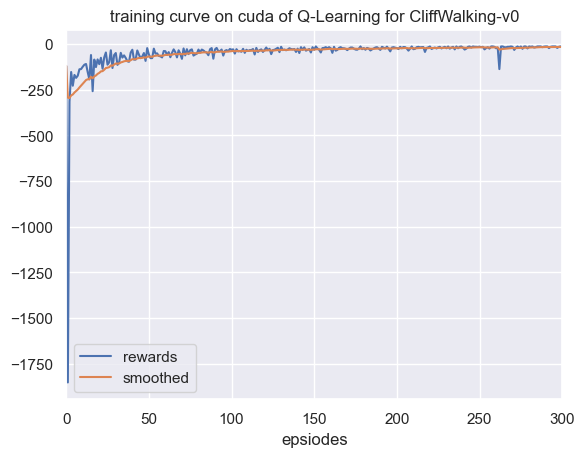

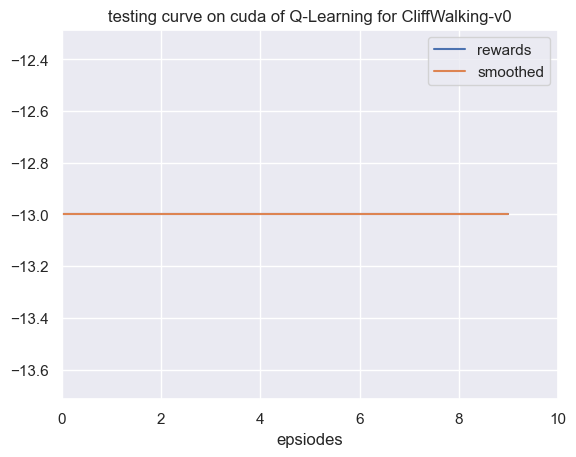

In [41]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
train_res_dic = train(cfg, env, agent)
 
plot_rewards(train_res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
test_res_dic = test(cfg, env, agent)
plot_rewards(test_res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果

In [42]:
print(f"测试的动作列表：{test_res_dic['actions_lis'][0]}")

测试的动作列表：[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
